In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D

In [2]:
def extract_activity(record):
    try:
        return record["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"
    
def parse_json(json):
    points = [sg.Point(xy) for xy in zip(json.locations.apply(lambda x: x["longitudeE7"] / 10000000),
                                    json.locations.apply(lambda x: x["latitudeE7"] / 10000000))]
    df = gp.GeoDataFrame(geometry=points)
    locations = json.locations
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x["timestampMs"], unit='ms'))
#     df["accuracy"] = locations.apply(lambda x: x["accuracy"])
#     df["velocity"] = locations.apply(lambda x: x.get("velocity", None))
#     df["heading"] = locations.apply(lambda x: x.get("heading", None))
#     df["altitude"] = locations.apply(lambda x: x.get("altitude", None))
#     df["activity"] = locations.apply(extract_activity)
    return df
 
%time df = parse_json(pd.read_json(r"google_lera\Takeout\История местоположений\История местоположений.json"))

Wall time: 2min 6s


In [5]:
df.head(100)

,geometry,timestamp
0,POINT (37.72644 55.81231),2017-07-20 18:58:15.010
1,POINT (37.72644 55.81231),2017-07-20 19:06:49.123
2,POINT (37.72644 55.81231),2017-07-20 19:08:45.266
3,POINT (37.72644 55.81231),2017-07-20 19:24:16.374
4,POINT (37.72644 55.81231),2017-07-20 19:24:47.377
...,...,...
95,POINT (37.72542 55.80932),2017-07-21 08:16:27.430
96,POINT (37.72544 55.80936),2017-07-21 08:16:49.412
97,POINT (37.72539 55.80932),2017-07-21 08:18:41.530
98,POINT (37.72539 55.80932),2017-07-21 08:19:02.711


In [4]:
world = gp.read_file('maps\TM_WORLD_BORDERS-0.3\TM_WORLD_BORDERS-0.3.shp')

moscow = gp.read_file('maps\mosbld\mosbld.shp')

 
def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,16))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    ax = box_only.plot(ax=base, marker='o', markersize=8)

In [5]:
def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()
 
 
def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()
 
 
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")
    
 
def draw_map(df, box, amap):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = amap.plot(color='white', edgecolor='silver', figsize=(14,10))
#     base = moscow.plot(color='white', edgecolor='silver', figsize=(14,10))

    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', c=pal, markersize=8)
    compute_legend(box_only, ax, cmap, 5)

In [6]:
# draw_map(df, sg.box(-140, -20, 140, 70))



Bad key "text.kerning_factor" on line 4 in
C:\Users\Lera\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


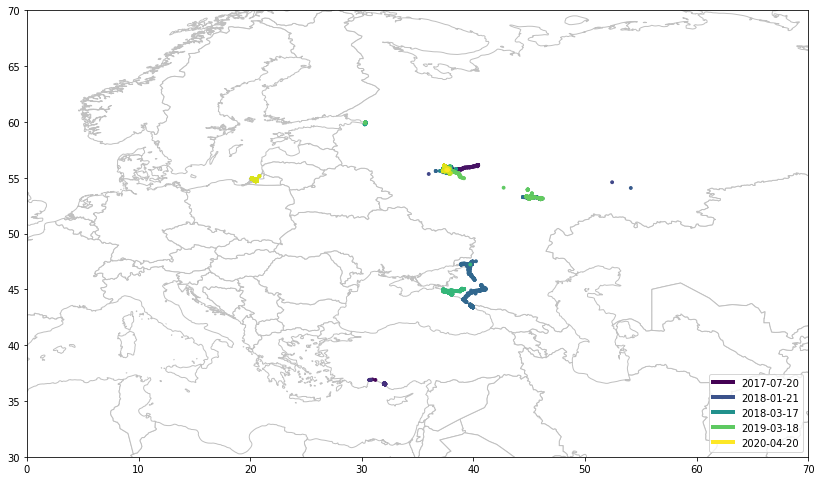

In [7]:
draw_map(df, sg.box(0, 30, 70, 70), world)


In [10]:
# draw_map(df, sg.box(15, 33, 60, 65))


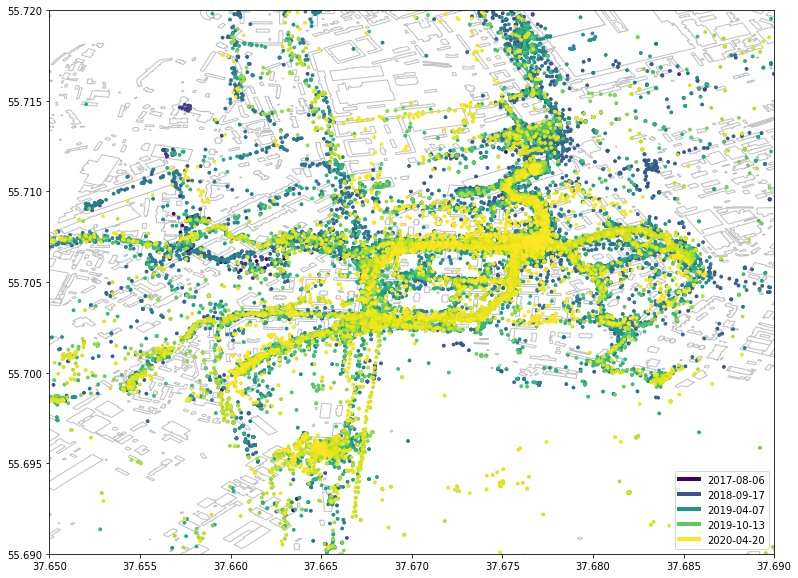

In [8]:
draw_map(df, sg.box(37.65, 55.69, 37.69, 55.72), moscow)

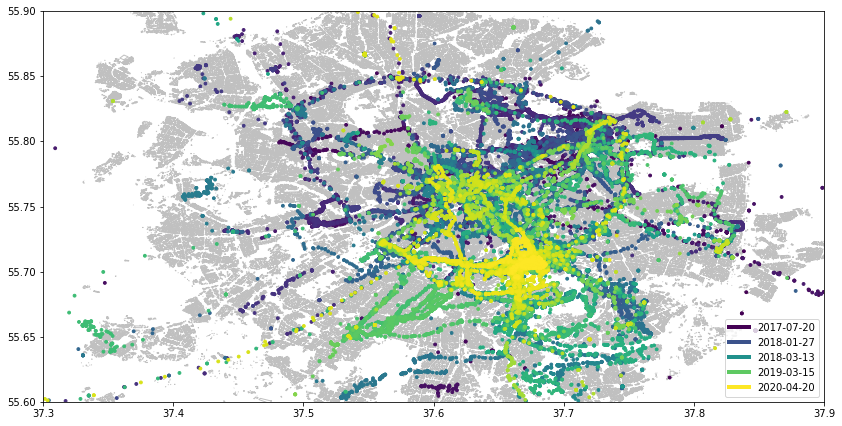

In [14]:
draw_map(df, sg.box(37.3, 55.6, 37.9, 55.9))